In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
%matplotlib inline

In [73]:
train_data = '../data/用例示例/TrainData_2015.1.1_2015.2.19.txt'
test_data = '../data/用例示例/TestData_2015.2.20_2015.2.27.txt'
df = pd.read_csv(train_data, delimiter='\t', header=None, 
                names=['vm-id', 'vm-name', 'create_at'],
                parse_dates=['create_at'])
df_test = pd.read_csv(test_data, delimiter='\t', header=None, 
                names=['vm-id', 'vm-name', 'create_at'],
                parse_dates=['create_at'])
df = df.append(df_test)
df['create_date'] = df['create_at'].apply(lambda x: x.date())

In [74]:
df.tail()

,vm-id,vm-name,create_at,create_date
56,56498dfb-80da,flavor9,2015-02-26 23:31:15,2015-02-26
57,56498dfc-91e7,flavor9,2015-02-26 23:31:25,2015-02-26
58,56498dfd-994c,flavor9,2015-02-26 23:31:52,2015-02-26
59,56498dfe-9564,flavor9,2015-02-26 23:31:52,2015-02-26
60,56498dff-a8d8,flavor9,2015-02-26 23:32:28,2015-02-26


In [75]:
interval = df.create_date.unique()

In [76]:
flavors_complete = {}
for flavor in df['vm-name'].unique():
    f = df[df['vm-name'] == flavor].groupby('create_date')['vm-name'].count()
    for intval in interval:
        if intval not in f:
            f = f.append(pd.Series({intval: 0})).sort_index()
            frame = f.to_frame().rename(columns={0: 'count'})
            frame['cumsum'] = frame['count'].cumsum()

    flavors_complete[flavor] = frame

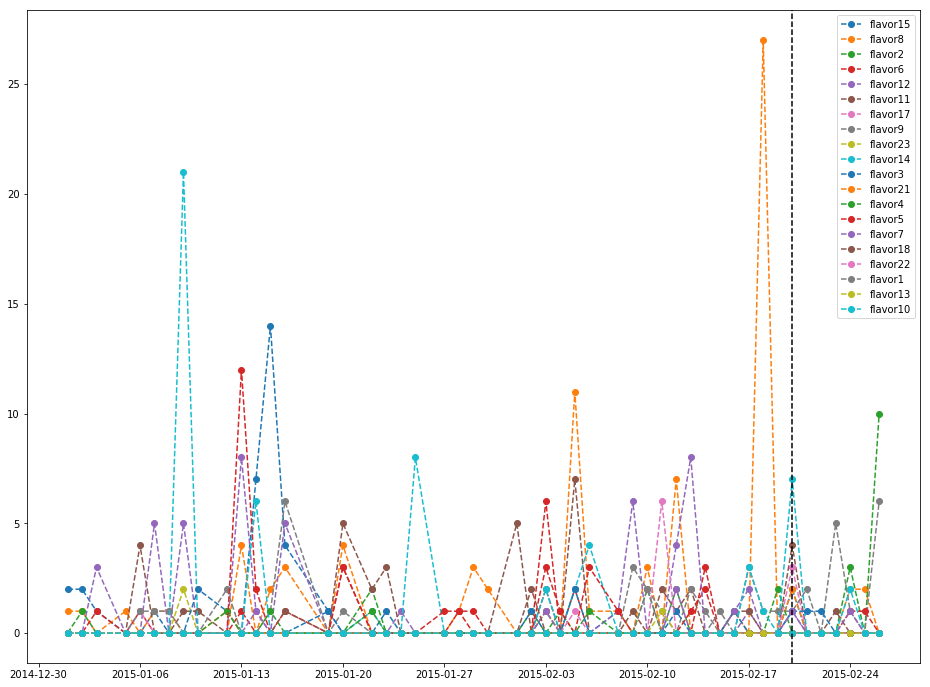

In [82]:
plt.figure(figsize=(16, 12))
for vm_name, flavor in flavors_complete.items():  
    plt.plot(flavor.index, flavor['count'], 'o--', label=vm_name)
plt.axvline(x=date(2015, 2, 20), color='k', linestyle='--')
plt.legend()

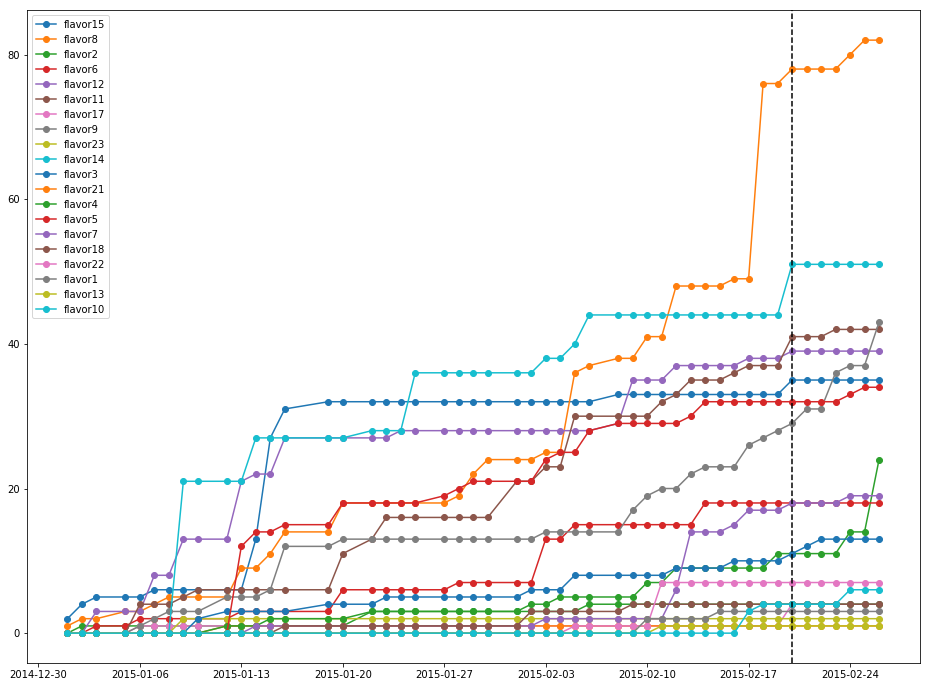

In [85]:
plt.figure(figsize=(16, 12))
for vm_name, flavor in flavors_complete.items():  
    plt.plot(flavor.index, flavor['cumsum'], 'o-', label=vm_name)
plt.axvline(x=date(2015, 2, 20), color='k', linestyle='--')
plt.legend()

In [54]:
f15 = flavors_complete['flavor15']
f15.loc[date(2015, 1, 1):date(2015, 1, 8)]['count'].sum()

6

In [124]:
def getCount(vm_name, start_date, during_days):
    flavor = flavors_complete[vm_name]
    return flavor.loc[start_date:start_date + timedelta(days=during_days-1)]['count'].sum()
        

In [125]:
fmt = '{:>10}{:>10}{:>10}{:>10}'
print(fmt.format('vm-name', 'last7', 'predict7', 'diff'))
for vm_name in flavors_complete:
    last7 = getCount(vm_name, date(2015, 2, 13), 7)
    next7 = getCount(vm_name, date(2015, 2, 20), 7)
    print(fmt.format(vm_name, last7, next7, next7 - last7))


   vm-name     last7  predict7      diff
  flavor15         0         2         2
   flavor8        28         6       -22
   flavor2         2        13        11
   flavor6         3         0        -3
  flavor12         1         1         0
  flavor11         4         5         1
  flavor17         0         3         3
   flavor9         8        15         7
  flavor23         0         0         0
  flavor14         0         7         7
   flavor3         1         3         2
  flavor21         0         0         0
   flavor4         0         0         0
   flavor5         3         2        -1
   flavor7        11         2        -9
  flavor18         0         0         0
  flavor22         0         0         0
   flavor1         1         0        -1
  flavor13         0         0         0
  flavor10         4         2        -2


In [123]:
flavors_complete['flavor8']

,count,cumsum
2015-01-01,1,1
2015-01-02,1,2
2015-01-03,0,2
2015-01-05,1,3
2015-01-06,0,3
2015-01-07,1,4
2015-01-08,1,5
2015-01-09,0,5
2015-01-10,0,5
2015-01-12,0,5


0